In [1]:
import pandas as pd
import numpy as np
import darts
from scipy import stats
from darts import TimeSeries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from darts.metrics.metrics import mape, mae, mse, ape

In [2]:
def calculate_95_ci(data):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.norm.ppf((1 + 0.95) / 2.)
    return (mean - h, mean + h)

In [69]:
df = pd.read_csv('../../DataSet/EDvisitfileL.csv', encoding='ISO-8859-1')

# 確保 'date' 列是 DateTime 類型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 創建實際數據的 TimeSeries 物件
Real_series = TimeSeries.from_dataframe(df, value_cols='No')

# 讀取 Result 資料夾中的 CSV 文件
Prediction_series_df = pd.read_csv('../../Result/SARIMA/Linkou/FH30.csv', encoding='ISO-8859-1')
Prediction_series_df['time'] = pd.to_datetime(Prediction_series_df['time'])
Prediction_series_df.set_index('time', inplace=True)

# 創建預測數據的 TimeSeries 物件
Prediction_series = TimeSeries.from_dataframe(Prediction_series_df, value_cols='No')

In [70]:
# 取出共同的時間索引，並裁剪兩個 series
common_time_index = Real_series.time_index.intersection(Prediction_series.time_index)
Real_series = Real_series.slice(common_time_index.min(), common_time_index.max())
Prediction_series = Prediction_series.slice(common_time_index.min(), common_time_index.max())

# 計算 APE 直接使用 Darts 提供的內建 ape 函數
APE = ape(Real_series, Prediction_series)

# 將 APE 結果轉換為 DataFrame
APEdf = pd.DataFrame(APE, columns=['APE'])
APEdf.index = common_time_index

In [71]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    # 使用TimeSeries的slice方法按年份切片
    # 注意：这里假设时间索引类型是pd.DatetimeIndex
    yearly_series = Prediction_series.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    
    # 将每年的TimeSeries转换为DataArray并存储在字典中
    yearly_dataarrays[year] = yearly_series.data_array()

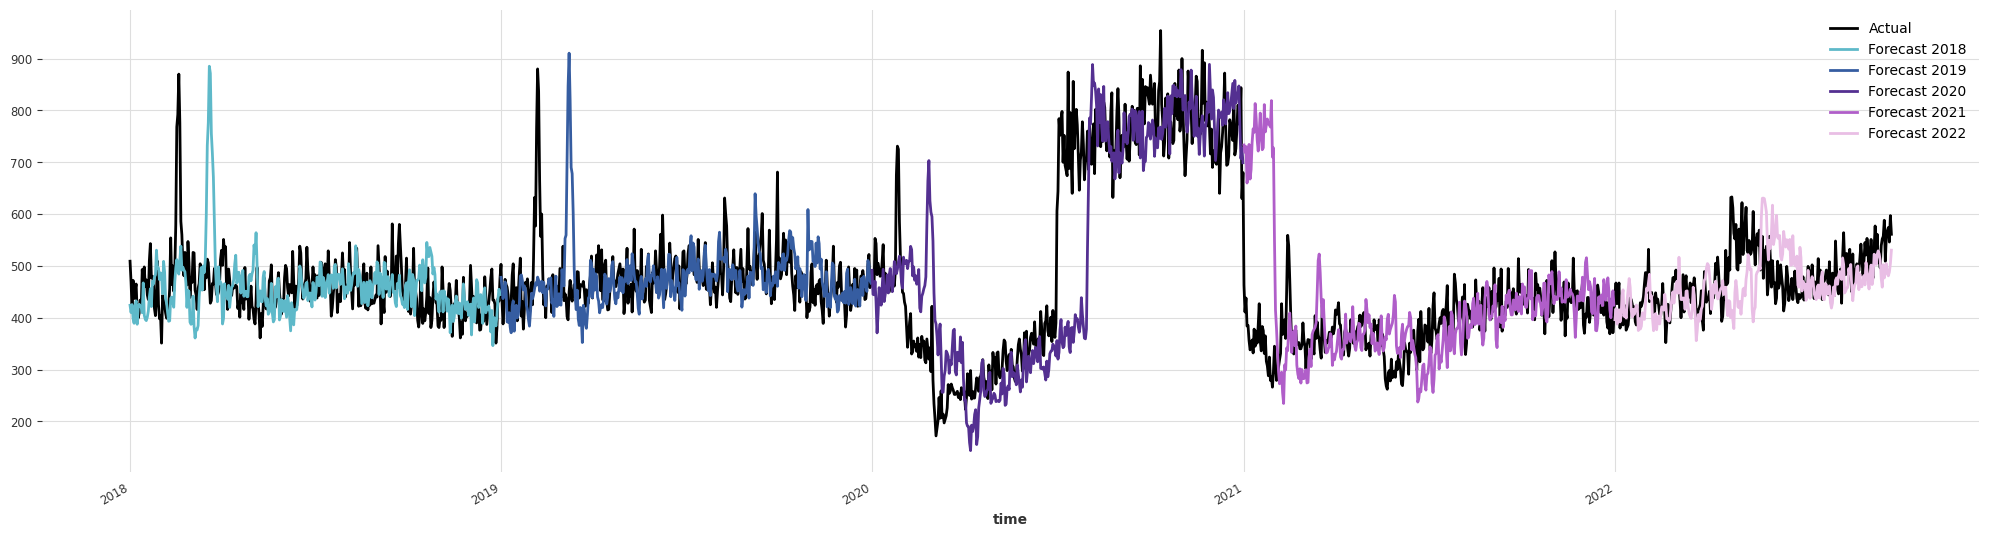

In [72]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
Real_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [73]:
metrics = {}
ape_2018_2019 = []
ape_2020_2021 = []
ape_2022 = []
for year in range(2018, 2023):
    # 从all_series中提取相应年份的实际数据
    actual = Real_series.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    forecast = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    mae_value = mae(actual, forecast)
    mape_value = mape(actual, forecast)
    
    # 从APEdf中提取相应年份的APE数据
    ape_yearly = APEdf.loc[f'{year}-01-01':f'{year}-12-31', 'APE']
    
    # 根据年份将APE数据添加到相应列表中
    if year in [2018, 2019]:
        ape_2018_2019.extend(ape_yearly)
    elif year in [2020, 2021]:
        ape_2020_2021.extend(ape_yearly)
    elif year in [2022]:
        ape_2022.extend(ape_yearly)
    # 计算95%置信区间
    ci_95 = calculate_95_ci(ape_yearly)

    metrics[year] = {
        "MAE": mae_value,
        "MAPE": mape_value,
        "APE 95% CI": ci_95
    }

ci_95_2018_2019 = calculate_95_ci(ape_2018_2019)
mape_2018_2019 = np.mean(ape_2018_2019)
ci_95_2020_2021 = calculate_95_ci(ape_2020_2021)
mape_2020_2021 = np.mean(ape_2020_2021)
ci_95_2022 = calculate_95_ci(ape_2022)
mape_2022 = np.mean(ape_2022)
ci_all = calculate_95_ci(APEdf['APE'])
mape_all = np.mean(APEdf['APE'])
# 打印结果
for year, m in metrics.items():
    print(f"Year {year}: MAE = {m['MAE']:.2f}, MAPE = {m['MAPE']:.2f}%, APE 95% CI = ({m['APE 95% CI'][0]:.2f}, {m['APE 95% CI'][1]:.2f})")

print(f"2018-2019 Combined: MAPE = {mape_2018_2019:.2f}%, APE 95% CI = ({ci_95_2018_2019[0]:.2f}, {ci_95_2018_2019[1]:.2f})")
print(f"2020-2021 Combined: MAPE = {mape_2020_2021:.2f}%, APE 95% CI = ({ci_95_2020_2021[0]:.2f}, {ci_95_2020_2021[1]:.2f})")
print(f"2022              : MAPE = {mape_2022:.2f}%, APE 95% CI = ({ci_95_2022[0]:.2f}, {ci_95_2022[1]:.2f})")
print(f"2018-2022 Combined: MAPE = {mape_all:.2f}%, APE 95% CI = ({ci_all[0]:.2f}, {ci_all[1]:.2f})")

Year 2018: MAE = 48.87, MAPE = 10.50%, APE 95% CI = (9.33, 11.68)
Year 2019: MAE = 45.90, MAPE = 9.46%, APE 95% CI = (8.22, 10.69)
Year 2020: MAE = 91.68, MAPE = 19.10%, APE 95% CI = (16.98, 21.23)
Year 2021: MAE = 76.18, MAPE = 21.01%, APE 95% CI = (17.74, 24.27)
Year 2022: MAE = 47.86, MAPE = 9.80%, APE 95% CI = (8.86, 10.73)
2018-2019 Combined: MAPE = 9.98%, APE 95% CI = (9.13, 10.83)
2020-2021 Combined: MAPE = 20.05%, APE 95% CI = (18.11, 22.00)
2022              : MAPE = 9.80%, APE 95% CI = (8.86, 10.73)
2018-2022 Combined: MAPE = 14.20%, APE 95% CI = (13.26, 15.14)


In [74]:
metrics = {}
ape_2018_2019 = []
ape_2020_2021 = []
ape_2022 = []
ae_2018_2019 = []
ae_2020_2021 = []
ae_2022 = []

for year in range(2018, 2023):
    # 从all_series中提取相应年份的实际数据
    actual = Real_series.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    forecast = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # Calculate metrics
    mae_value = mae(actual, forecast)
    mape_value = mape(actual, forecast)
    
    # Calculate absolute error (AE)
    actual_values = actual.values().flatten()
    forecast_values = forecast.values().flatten()
    ae_values = np.abs(actual_values - forecast_values)  # Absolute Error
    
    # 从APEdf中提取相应年份的APE数据
    ape_yearly = APEdf.loc[f'{year}-01-01':f'{year}-12-31', 'APE']
    
    # 根据年份将APE和AE数据添加到相应列表中
    if year in [2018, 2019]:
        ape_2018_2019.extend(ape_yearly)
        ae_2018_2019.extend(ae_values)
    elif year in [2020, 2021]:
        ape_2020_2021.extend(ape_yearly)
        ae_2020_2021.extend(ae_values)
    elif year in [2022]:
        ape_2022.extend(ape_yearly)
        ae_2022.extend(ae_values)
    
    # 计算95%置信区间
    ci_95 = calculate_95_ci(ape_yearly)
    
    # Store the metrics for the year
    metrics[year] = {
        "MAE": mae_value,
        "MAPE": mape_value,
        "APE 95% CI": ci_95,
        "AE": ae_values  # Store absolute error
    }

# Combined metrics for 2018-2019, 2020-2021, and 2022
ci_95_2018_2019 = calculate_95_ci(ape_2018_2019)
mape_2018_2019 = np.mean(ape_2018_2019)
ae_2018_2019_mean = np.mean(ae_2018_2019)

ci_95_2020_2021 = calculate_95_ci(ape_2020_2021)
mape_2020_2021 = np.mean(ape_2020_2021)
ae_2020_2021_mean = np.mean(ae_2020_2021)

ci_95_2022 = calculate_95_ci(ape_2022)
mape_2022 = np.mean(ape_2022)
ae_2022_mean = np.mean(ae_2022)

ci_all = calculate_95_ci(APEdf['APE'])
mape_all = np.mean(APEdf['APE'])
ae_all = np.mean(np.abs(Real_series.values().flatten() - Prediction_series.values().flatten()))

# 打印结果
for year, m in metrics.items():
    print(f"Year {year}: MAE = {m['MAE']:.2f}, MAPE = {m['MAPE']:.2f}%, APE 95% CI = ({m['APE 95% CI'][0]:.2f}, {m['APE 95% CI'][1]:.2f})")
    # Print Absolute Error (AE) statistics like mean AE or directly output AE values
    #print(f"Year {year}: Mean AE = {np.mean(m['AE']):.2f}")

print(f"2018-2019 Combined: MAPE = {mape_2018_2019:.2f}%, APE 95% CI = ({ci_95_2018_2019[0]:.2f}, {ci_95_2018_2019[1]:.2f}), MAE = {ae_2018_2019_mean:.2f}")
print(f"2020-2021 Combined: MAPE = {mape_2020_2021:.2f}%, APE 95% CI = ({ci_95_2020_2021[0]:.2f}, {ci_95_2020_2021[1]:.2f}), MAE = {ae_2020_2021_mean:.2f}")
print(f"2022              : MAPE = {mape_2022:.2f}%, APE 95% CI = ({ci_95_2022[0]:.2f}, {ci_95_2022[1]:.2f}), MAE = {ae_2022_mean:.2f}")
print(f"2018-2022 Combined: MAPE = {mape_all:.2f}%, APE 95% CI = ({ci_all[0]:.2f}, {ci_all[1]:.2f}), MAE = {ae_all:.2f}")


Year 2018: MAE = 48.87, MAPE = 10.50%, APE 95% CI = (9.33, 11.68)
Year 2019: MAE = 45.90, MAPE = 9.46%, APE 95% CI = (8.22, 10.69)
Year 2020: MAE = 91.68, MAPE = 19.10%, APE 95% CI = (16.98, 21.23)
Year 2021: MAE = 76.18, MAPE = 21.01%, APE 95% CI = (17.74, 24.27)
Year 2022: MAE = 47.86, MAPE = 9.80%, APE 95% CI = (8.86, 10.73)
2018-2019 Combined: MAPE = 9.98%, APE 95% CI = (9.13, 10.83), MAE = 47.38
2020-2021 Combined: MAPE = 20.05%, APE 95% CI = (18.11, 22.00), MAE = 83.94
2022              : MAPE = 9.80%, APE 95% CI = (8.86, 10.73), MAE = 47.86
2018-2022 Combined: MAPE = 14.20%, APE 95% CI = (13.26, 15.14), MAE = 62.87
